# Analyzing State Supermajorities


- The data for this analysis comes from [Ballotpedia](https://ballotpedia.org/) and contains data that classifies states according to the degree of "monopoly" a political party has over the state's government and how long that state's monopoly has been in place.
- I encourage you to check out the analysis [here](https://ballotpedia.org/State_government_trifectas) which is where the data is source from.
- For the remainder of this report, I will use the word "Trifecta" instead of "Monopoly".

Ballotpedia classifies states in different types of **Trifectas**. Below is Ballotpedia's definition for `Trifectas`:

> State government trifecta is a term to describe single-party government, 
when one political party holds the governorship and majorities 
in both chambers of the state legislature. 


**Below I collect the dataset from Ballotpedia's website**

In [1]:
from pathlib import Path
import pandas as pd
import geopandas as gpd
from datetime import datetime
import matplotlib.pyplot as plt
from IPython.display import display
import matplotlib.patches as mpatches

df = pd.read_html('https://ballotpedia.org/State_government_trifectas')[4]
df.head()

Trifecta status by state                                                  \
                     State      Trifecta status Year of last status change   
0                  Alabama  Republican trifecta                       2011   
1                   Alaska   Divided government                       2015   
2                  Arizona  Republican trifecta                       2009   
3                 Arkansas  Republican trifecta                       2015   
4               California  Democratic trifecta                       2011   

                      
  Unnamed: 3_level_1  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN

**Next I...**
- Drop unecessary columns
- Add a column that counts the number years since the status of the state's trifecta has changed

In [2]:
df.columns = df.columns.droplevel().str.lower().str.replace(' ', '_')
df = df[[x for x in df.columns if 'unnamed' not in x]]
df = df.assign(years_with_trifecta=datetime.now().year - df.year_of_last_status_change.astype(int))
display(df.head())

,state,trifecta_status,year_of_last_status_change,years_with_trifecta
0,Alabama,Republican trifecta,2011,11
1,Alaska,Divided government,2015,7
2,Arizona,Republican trifecta,2009,13
3,Arkansas,Republican trifecta,2015,7
4,California,Democratic trifecta,2011,11


**Next I filter out states with a "Diveded government" status because they different bodies of the state government are controlled by different political parties**

In [3]:
df = df.query('~trifecta_status.str.contains("Divided")')

### How many states have a current trifecta?

In [4]:
print('States with trifecta:', df.shape[0])

States with trifecta: 37


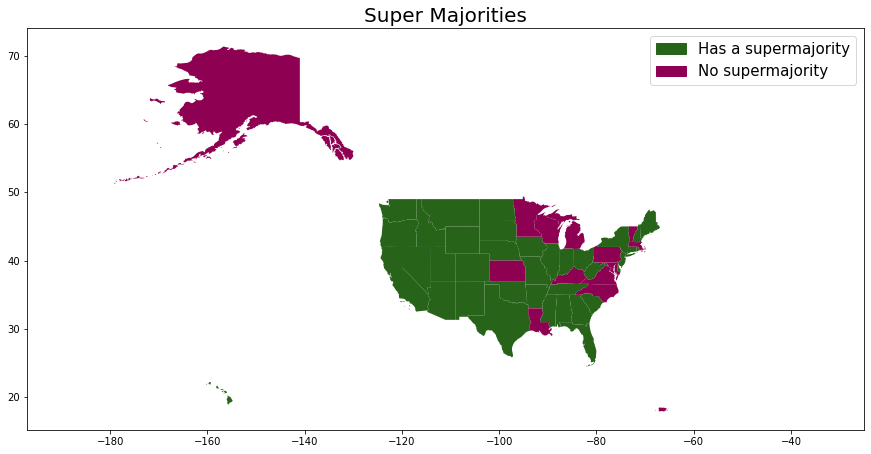

In [5]:
state_abbreviations = pd.read_html('https://www.bu.edu/brand/guidelines/editorial-style/us-state-abbreviations/', header=0)[0]
abbreviations = {}
nones = state_abbreviations.apply(lambda row: {row.iloc[0]: row.iloc[-1]}, axis=1).apply(lambda x: abbreviations.update(x))
df = df.assign(abbreviation=df.state.map(abbreviations))

fig, ax = plt.subplots(figsize=(15,10))
shapefile_path = str(Path('.') / 'shapefiles' /'cb_2018_us_state_20m.shp')
geo_file = gpd.read_file(shapefile_path).assign(supermajority=lambda x: x.STUSPS.isin(df.abbreviation.to_list()).astype(int))
geo_file.plot(column='supermajority', ax=ax, cmap='PiYG')
ax.set_xlim(right=-25)
ax.set_title('Super Majorities', fontsize=20)
green_patch = mpatches.Patch(color='#276419', label='Has a supermajority')
pink_patch = mpatches.Patch(color='#8e0152', label='No supermajority')
plt.legend(handles=[green_patch, pink_patch], fontsize=15);

### How long on average have states held their current trifectas?

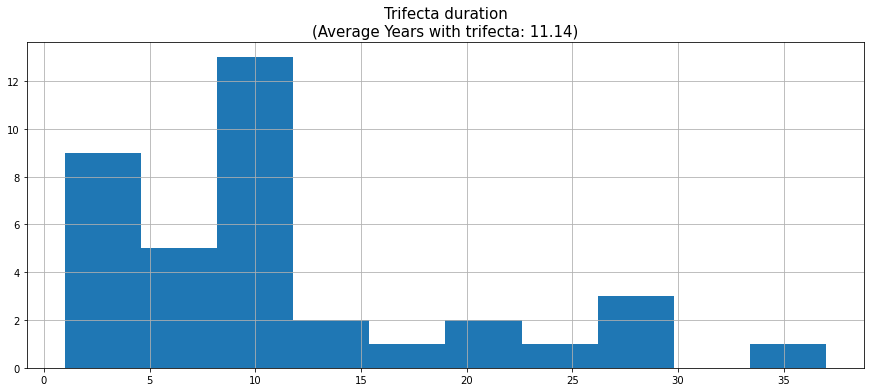

In [6]:
average_years_trifecta = round(df.years_with_trifecta.mean(), 2)
df.years_with_trifecta.hist(figsize=(15,6))
plt.title(f'Trifecta duration\n(Average Years with trifecta: {average_years_trifecta})', fontsize=15);

### How many trifecta does each party have?

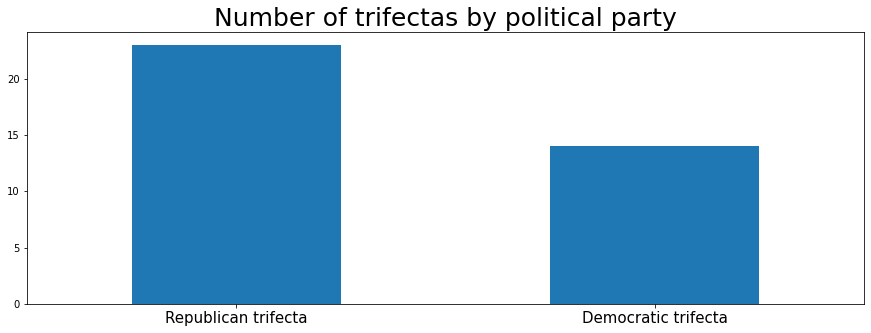

In [7]:
df.trifecta_status.value_counts().plot(kind='bar', figsize=(15,5))
plt.xticks(rotation=0, fontsize=15)
plt.title('Number of trifectas by political party', fontsize=25);

### What is the average amount of years each party has held their trifecta?

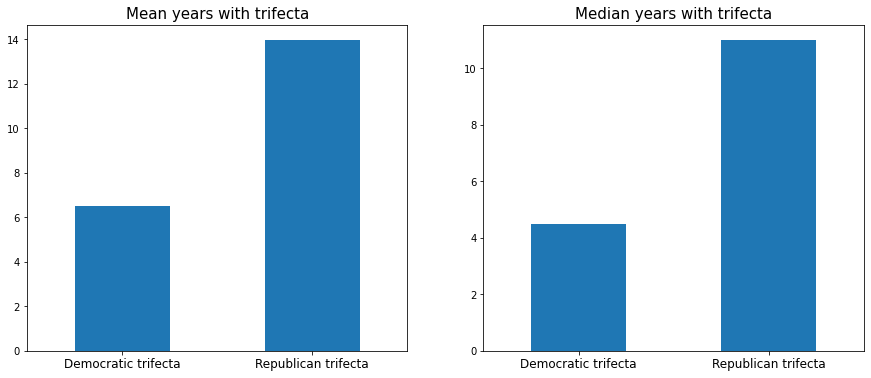

In [8]:
fig, ax = plt.subplots(1,2, figsize=(15,6))

df.groupby('trifecta_status').years_with_trifecta.mean().plot(kind='bar', ax=ax[0])
for label in ax[0].get_xticklabels():
    label.set_rotation(0)
    label.set_fontsize(12)
    
df.groupby('trifecta_status').years_with_trifecta.median().plot(kind='bar', ax=ax[1])
for label in ax[1].get_xticklabels():
    label.set_rotation(0)
    label.set_fontsize(12)

ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[0].set_title('Mean years with trifecta', fontsize=15)
ax[1].set_title('Median years with trifecta', fontsize=15);